In [10]:
import sys 
sys.path.append('ldm/')
sys.path.append('../autoencoder/')

In [11]:
# set this before importing torch
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd

In [22]:
from moler_ldm import LatentDiffusion
import torch
from dataset import LincsDataset, MolerDataset
from torch_geometric.loader import DataLoader
from omegaconf import OmegaConf
from model_utils import get_params
from tqdm import tqdm
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from datetime import datetime
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like
from DDIM import MolSampler


In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.drawOptions.baseFontSize = 0.5
IPythonConsole.ipython_useSVG=True

In [38]:
device = torch.device("cpu")

# Unconstrained GLDM (WAE)

In [31]:
ckpt_path = 'model_ckpt/GLDM_WAE_uncond.ckpt'
checkpoint = torch.load(ckpt_path, map_location = device)
config_file = 'config/ldm_uncon+wae_uncon.yml'
config = OmegaConf.load(config_file)
ldm_params = config['model']['params']

# args
batch_size = 1
NUM_WORKERS = 4
train_split1 = "train_0"
valid_split = "valid_0"

layer_type = "FiLMConv"
model_architecture = 'aae'
gradient_clip_val = 1.0
max_lr = 1e-5
gen_step_drop_probability = 0
use_oclr_scheduler = True
using_cyclical_anneal = False
use_clamp_log_var = False

raw_moler_trace_dataset_parent_folder = "/data/ongh0068/guacamol/trace_dir"
# raw_moler_trace_dataset_parent_folder = "/data/ongh0068/l1000/TRACE_DIR"
output_pyg_trace_dataset_parent_folder = (
    "/data/ongh0068/l1000/already_batched"
)

In [16]:
dataset = LincsDataset(
    root="/data/ongh0068",
    raw_moler_trace_dataset_parent_folder="/data/ongh0068/guacamol/trace_dir",
    output_pyg_trace_dataset_parent_folder="/data/ongh0068/l1000/already_batched",
    split="valid_0",
    gene_exp_controls_file_path="/data/ongh0068/l1000/lincs/robust_normalized_controls.npz",
    gene_exp_tumour_file_path="/data/ongh0068/l1000/lincs/robust_normalized_tumors.npz",
    lincs_csv_file_path="/data/ongh0068/l1000/lincs/experiments_filtered.csv",
)

Loading controls gene expression...
Loading tumour gene expression...
Loading csv...


In [17]:
first_stage_params = get_params(dataset)
first_stage_config = config['model']['first_stage_config']
ldm_params = config['model']['params']
unet_params = config['model']['unet_config']['params']
first_stage_params["gene_exp_condition_mlp"]["input_feature_dim"] = 832 + 978 + 1

{'image_size': 512, 'in_channels': 1, 'out_channels': 1, 'model_channels': 64, 'dims': 1, 'attention_resolutions': [4, 2], 'num_res_blocks': 1, 'channel_mult': [1, 2, 3], 'num_head_channels': 8}

In [21]:
ldm_model = LatentDiffusion(
    first_stage_config,
    config['model']['cond_stage_config'],
    dataset, 
    gen_step_drop_probability,
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config['model']['unet_config'],
    **ldm_params
)
ldm_model.load_state_dict(checkpoint['state_dict'])
ldm_model.to(device=device)
ldm_model.eval()

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 3.49 M params.


LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=256, out_features=64, bias=True)
            )
            (out_layers): Sequential(
              (0): GroupNorm32(32, 64, e

In [23]:
sampler = MolSampler(ldm_model)

In [26]:
n_samples = 10
ddim_steps=500
ddim_eta=1.0
size = (1, 512)

samples, _ = sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    shape = size,
    ddim_eta = ddim_eta
)

Selected timesteps for ddim sampler: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286
 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322
 324 326 328 330 332 334 336 338 340 342 344 346 348 350 352 354 356 358
 360 362 364 366 368 370 372 374 376 378 380 382 384 386 388 390 392 394
 396 398 400 402 404 406 408 410 412 414 416 418 420 422 424 426 428 430
 432 434 436 438 440 442 444 446 448 450 452 454 456 458 460 462 464 466
 468 470 472 4

DDIM Sampler: 100%|███████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.14it/s]


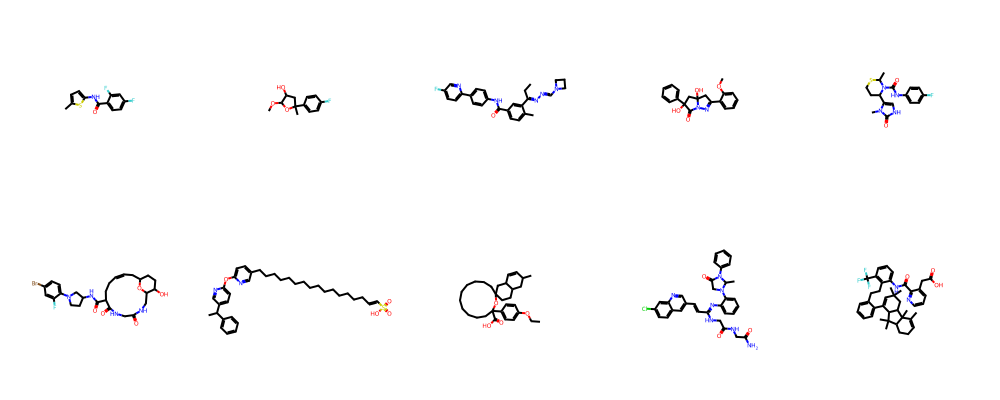

In [28]:
z = samples.view((n_samples, 512))
decoder_states = ldm_model.first_stage_model.decode(
    latent_representations=z, max_num_steps=120
)
Draw.MolsToGridImage([decoder_states[i].molecule for i in range(len(decoder_states))], subImgSize=(200,200), maxMols = 1000, molsPerRow=5)

# Constrained GLDM (WAE)
> the only difference is that gene expression data is used as the input of the sampler

In [39]:
ckpt_path = 'model_ckpt/GLDM_WAE_cond.ckpt'
checkpoint = torch.load(ckpt_path, map_location = device)
config_file = 'config/ldm_con+wae_con.yml'
config = OmegaConf.load(config_file)
ldm_params = config['model']['params']

first_stage_params = get_params(dataset)
first_stage_config = config['model']['first_stage_config']
ldm_params = config['model']['params']
unet_params = config['model']['unet_config']['params']
first_stage_params["gene_exp_condition_mlp"]["input_feature_dim"] = 832 + 978 + 1

In [40]:
ldm_model = LatentDiffusion(
    first_stage_config,
    config['model']['cond_stage_config'],
    dataset, 
    gen_step_drop_probability,
    batch_size,
    first_stage_params,
    first_stage_config['ckpt_path'],
    unet_config = config['model']['unet_config'],
    **ldm_params
)
ldm_model.load_state_dict(checkpoint['state_dict'])
ldm_model.to(device=device)
ldm_model.eval()

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 8.91 M params.


LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=256, out_features=64, bias=True)
            )
            (out_layers): Sequential(
              (0): GroupNorm32(32, 64, e

In [42]:
cond_sampler = MolSampler(ldm_model)

In [43]:
n_samples = 10
pseudo_gene_expr_dose = torch.rand((n_samples, 1, 979))  # change this into real gene expression + dosage data
pseudo_gene_expr_dose.to(device)

cond_samples, _ = cond_sampler.sample(
    S = ddim_steps,
    batch_size = n_samples,  # not batch size
    conditioning = pseudo_gene_expr_dose,
    shape = size,
    ddim_eta = ddim_eta
)

Selected timesteps for ddim sampler: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286
 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322
 324 326 328 330 332 334 336 338 340 342 344 346 348 350 352 354 356 358
 360 362 364 366 368 370 372 374 376 378 380 382 384 386 388 390 392 394
 396 398 400 402 404 406 408 410 412 414 416 418 420 422 424 426 428 430
 432 434 436 438 440 442 444 446 448 450 452 454 456 458 460 462 464 466
 468 470 472 4

Data shape for DDIM sampling is (10, 1, 512), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████████████| 500/500 [06:59<00:00,  1.19it/s]


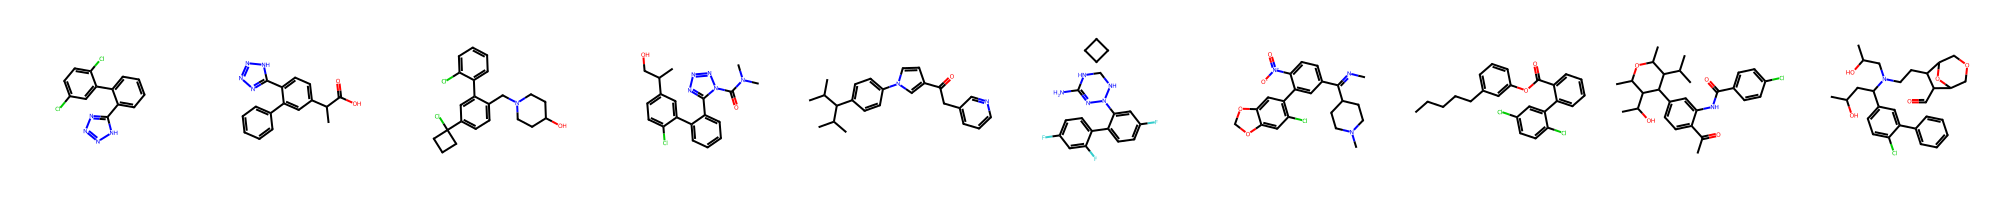

In [46]:
decoding_samples = cond_samples.view((n_samples, unet_params.image_size))
decoding_res = ldm_model.first_stage_model.decode(decoding_samples)
img = Draw.MolsToGridImage([decoding_res[i].molecule for i in range(len(decoding_res))], subImgSize=(200,200), maxMols = 1000, molsPerRow=10,)
img